# Homework 3: Neural Networks


This assignment is due on Moodle by **11:59pm on Friday October 25**. 
Your solutions to theoretical questions should be done in Markdown/MathJax directly below the associated question.
Your solutions to computational questions should include any specified Python code and results 
as well as written commentary on your conclusions.
Remember that you are encouraged to discuss the problems with your instructors and classmates, 
but **you must write all code and solutions on your own**. For a refresher on the course **Collaboration Policy** click [here](https://github.com/BoulderDS/CSCI5622-Machine-Learning/blob/master/info/syllabus.md#collaboration-policy).


**NOTES**: 

- Do **NOT** load or use any Python packages that are not available in Anaconda (Version: 2019.07) with Python 3.7. 
- Some problems with code may be autograded.  If we provide a function API **do not** change it.  If we do not provide a function API then you're free to structure your code however you like. 
- Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. 
- In this homework, we will use [Keras](https://keras.io/) to implement a classifier. First upgrade your `pip` package manager to the latest version (Version >19.0). Then install the current stable release for CPU-only of [TensorFlow](https://www.tensorflow.org/install) (version: 2.0.0) as the backend for Keras. We will use [`tf.keras`](https://www.tensorflow.org/api_docs/python/tf/keras) as our Keras API.
```
pip install --upgrade pip
pip install tensorflow
```
**Acknowledgment** : Chris Ketelsen

Name: Andrew Gerlach ange6809

In [1]:
import math
import pickle
import gzip
import numpy as np
import pandas
import matplotlib.pylab as plt
%matplotlib inline

[25 points] Problem 1 - Single-Layer and Multilayer Perceptron Learning
---

**Part 1 [15 points]:** Consider learning the following concepts with either a single-layer or multilayer perceptron where all hidden and output neurons utilize the *indicator* activation functions. For each of the following concepts, state whether the concept can be learned by a single-layer perceptron. Briefly justify your response by providing weights, biases, and the *indicator* activation functions if applicable:

- $\; \texttt{NOT } x_1$

- $\; x_1 \texttt{ NAND } x_2$

- $\; x_1 \texttt{ XNOR } x_2$ (output 1 when $x_1 = x_2$ and 0 otherwise)

NOT $x_1$ is one layer: $w$ = -1 $b$ = 0.5

$x_1$ NAND $x_2$ is also one layer: $w$ = $\begin{bmatrix}-1 &&-1 \end{bmatrix}$ $b$ = 1.5

$x_1$ XNOR $x_2$ cannot be done with a one-layer perceptron because the data is not linearly separable.

In all cases, the indicator function is $sign($wx$ + $b$)$

**Part 2 [10 points]:** Determine an architecture and specific values of the weights and biases in a single-layer or multilayer perceptron with *indicator* activation functions that can learn $x_1 \texttt{ XNOR } x_2$. Make a truth table of $x_1$, $x_2$, and $x_1 \texttt{ XNOR } x_2$, describe your perceptron's architecture, and state your weight matrices and bias vectors in Markdown below. Then demonstrate that your solution is correct by implementing forward propagation for your network in Python and showing that it produces the correct boolean output values for each of the four possible combinations of $x_1$ and $x_2$.

$x_1$ XNOR $x_2$ is a two-layer perceptron. The first layer has a matrix whose first row represents $x_1 AND x_2$ and whose second row represents $x_1 NAND x_2$. The result gets passed through the $sign$ indicator function. That result is then passed to the next layer which represents $x_1 OR x_2$. The result of this is also passed to the same indicator function which then determines the result.

$w_1$ = $\begin{bmatrix}1 & 1\\ -1 & -1 \end{bmatrix}$ $b_1$ = $\begin{bmatrix} -1.5\\0.5 \end{bmatrix}$

$w_2$ = $\begin{bmatrix}1 \\1 \end{bmatrix}$ $b_2$ = -0.5

\begin{array}{|c c|c|}
x_1 & x_2 & x_1 XNOR x_2\\
\hline
0 & 0 & 1\\
1 & 0 & 0\\
0 & 1 & 0\\
1 & 1 & 1\\
\end{array}

In [2]:
# YOUR CODE HERE
#the sign(x) indicator function
def sign(x):
    #x is the vector result of wx + b
    vector_length = len(x)
    for i in range(vector_length):
        if x[i] > 0:
            x[i] = 1
        else:
            x[i] = 0
    return x
def xnor(x):
    # x is the vector representing x1 and x2
    w_1 = np.array([[1,1],[-1,-1]])
    b_1 = np.array([[-1.5],[0.5]])
    w_2 = np.array([[1,1]])
    b_2 = np.array([-0.5])
    res_1 = sign(np.dot(w_1,x) + b_1)
    res_2 = sign(np.dot(w_2,res_1) + b_2)
    final_res = sign(res_2)
    return final_res


x_1 = np.array([[0],[0]])                        
x_2 = np.array([[1],[0]])
x_3 = np.array([[0],[1]])
x_4 = np.array([[1],[1]])
print("0 XNOR 0 = ",xnor(x_1))
print("1 XNOR 0 = ",xnor(x_2))
print("0 XNOR 1 = ",xnor(x_3))
print("1 XNOR 1 = ",xnor(x_4))

0 XNOR 0 =  [[1.]]
1 XNOR 0 =  [[0.]]
0 XNOR 1 =  [[0.]]
1 XNOR 1 =  [[1.]]


[25 points] Problem 2 - Back propagation
---

In this problem you will gain some intuition about why training deep neural networks can be very time consuming.  Consider training a chain-like neural network: 

![chain-like nn](figs/chain_net.png)

Note that this network has three weights $W^1, W^2, W^3$ and three biases $b^1, b^2,$ and $b^3$ (for this problem you can think of each parameter as a single value or as a $1 \times 1$ matrix). Suppose that each hidden and output neuron is equipped with a sigmoid activation function and the loss function is given by 

$$
\ell(y, a^4) = \frac{1}{2}(y - a^4)^2  
$$

where $a^4$ is the value of the activation at the output neuron and $y \in \{0,1\}$ is the true label associated with the training example. 

**Part 1 [5 points]:** Suppose each of the weights is initialized to $W^k = 1.0$ and each bias is initialized to $b^k = -0.5$.  Use forward propagation to find the activities and activations associated with each hidden and output neuron for the training example $(x, y) = (0.5,0)$. Show your work. 

\begin{equation*}
a^{(1)} = x = 0.5 \\
z^{(1)} = W^{(1)}x + b^{(1)} = (1.0)(0.5) + (-0.5) = 0.0           \\
a^{(2)} = \sigma(z^{(1)}) = 0.5                                     \\
z^{(2)} = W^{(2)}a^{(2)} + b^{(2)} = (1.0)(0.5) + (-0.5) = 0.0 \\
a^{(3)} = \sigma(z^{(2)}) = 0.5                                    \\
z^{(3)} = W^{(3)}a^{(3)} + b^{(3)} = (1.0)(0.5) + (-0.5) = 0.0 \\
a^{(4)} = \sigma(z^{(3)}) = 0.5                                      \\
\end{equation*}

**Part 2 [5 points]:** Use Back-Propagation to compute the weight and bias derivatives $\partial \ell / \partial W^k$ and $\partial \ell / \partial b^k$ for $k=1, 2, 3$.  Show all work. 

\begin{equation*}
\delta^{k} = (a^{k} - y)\sigma(z^{k})(1-\sigma(z^{k}) \\
\frac{\partial L}{\partial W^{k}} = \frac{\partial L}{\partial z^{k}}\frac{\partial z^{k}}{\partial W^{k}} = \delta^{k}\frac{\partial z^{k}}{\partial W^{k}} \\
\frac{\partial z^{k}}{\partial W^{k}} = a^{k-1} \\
\frac{\partial L}{\partial W^{k}} = \delta^{k}a^{k-1}
\frac{\partial L}{\partial b^{k}} = \delta^{k} \\ \\
\frac{\partial L}{\partial b^{1}} = \delta^{1} = (0.5 - 0)(0.5)(0.5) = 0.125  \\
\frac{\partial L}{\partial W^{1}} = \delta^{1}a^{0} = (0.125)(0.5) = 0.0625 \\
\frac{\partial L}{\partial b^{2}} = \delta^{2} = (0.5 - 0)(0.5)(0.5) = 0.125  \\
\frac{\partial L}{\partial W^{2}} = \delta^{2}a^{2-1} = (0.125)(0.5) = 0.0625  \\
\frac{\partial L}{\partial b^{3}} = \delta^{3} = (0.5 - 0)(0.5)(0.5) = 0.125  \\
\frac{\partial L}{\partial W^{3}} = \delta^{3}a^{3-1} = (0.125)(0.5) = 0.0625  \\
\end{equation*}

**Part 3 [5 points]:** Implement the following activation functions:
* ReLU
* Sigmoid
* softmax

In [3]:
def relu(x):
    if x < 0:
        return 0
    else:
        return x

def sigmoid(x):
    return 1/(1+math.exp(-1*x))

def softmax(x):
    # YOUR CODE HERE
    #exponentiate each value in the input
    vals = [math.exp(i) for i in x]
    #sum them for the denominator
    denom = sum(vals)
    s_max = [v/denom for v in vals]
    return s_max

In [4]:
# for grading - ignore
assert relu(5) == 5
assert relu(-5) == 0
assert relu(0) == 0
assert sigmoid(0.458) == 0.61253961344091512
assert sigmoid(2) == 0.8807970779778823
res = softmax([1,2,4])
temp = [0.04201007, 0.1141952 , 0.84379473]
for i in range(len(temp)):
    assert res[i] - temp[i] < 1e-5

**Part 4 [5 points]:** Implement the following Loss functions:
* mean squared error
* mean absolute error
* hinge

In [5]:
def mean_squared_error(yhat, y):
    # YOUR CODE HERE
    mse = np.square(np.subtract(yhat,y)).mean()
    return mse
    
def mean_absolute_error(yhat, y):
    # YOUR CODE HERE
    mae = np.absolute(np.subtract(yhat,y)).mean()
    return mae

def hinge(yhat, y):
    # YOUR CODE HERE
    if len(yhat) == len(y):
        res = 0
        for i in range(len(yhat)):
            prod = yhat[i] * y[i]
            curr = max(0, 1 - prod)
            res = res + curr
        return res/len(yhat)
    else:
        return 0

In [6]:
# for grading - ignore
y_true = np.array([3, -0.5, 2, 7])
y_pred = np.array([2.5, 0.0, 2, 8])
assert mean_squared_error(y_pred,y_true) == 0.375
assert mean_absolute_error(y_pred,y_true) == 0.5
assert hinge(y_pred,y_true) == 0.25

**Part 5 [5 points]:** Explain the vanishing gradient problem. When would you observe this? Give an example.

The vanishing gradient probelem arises when the partial derivatives become so small that the weights in the network update by an ever decreasing amount. The values of the derivatives can become so small that the network stops updating comletely and, in turn, stops learning. This is observed when the activation function has derivatives that range between 0 and 1, like ReLu or the sigmoid function.

[25 Points] Problem 3 - Build a feedforward neural network
---

In this problem you will implement a class representing a general feed-forward neural network that utilizes the sigmoid activation functions. Your tasks will be to implement forward propagation, prediction, back propagation, and a general train routine to learn the weights in your network via stochastic gradient descent.

The skeleton for the network class is below. Note that this class is almost identical to the one you worked with in the "hands-on neural network" in-class notebook, so you should look at there to remind yourself of the details. Scroll down to find more information about your tasks as well as unit tests.

**Part 1 [15 points]:** Implement `SGD_train`, `back_prop`, and `forward_prop`. Use the following test cases to verify if the code is working as expected.

In [9]:
import argparse
import numpy as np
import pickle
import gzip
import matplotlib.pyplot as plt


class Network:
    def __init__(self, sizes, keep_prob=-1):
        self.L = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(n, 1) for n in self.sizes[1:]]
        self.weights = [np.random.randn(n, m) for (
            m, n) in zip(self.sizes[:-1], self.sizes[1:])]
        self.keep_prob = keep_prob
        self.acc_train_array = []
        self.acc_test_array = []

    def g(self, z):
        """
        activation function
        """
        return sigmoid(z)

    def g_prime(self, z):
        """
        derivative of activation function
        """
        return sigmoid_prime(z)

    def forward_prop(self, a):
        """
        memory aware forward propagation for testing
        only.  back_prop implements it's own forward_prop
        """
        # YOUR CODE HERE
        for i in range(self.L - 1):
            z_i = np.dot(self.weights[i],a) + self.biases[i]
            a = self.g(z_i)
        return a

    def grad_cost(self, a, y):
        """
        gradient of cost function
        Assumes C(a,y) = (1/2)(a-y)^2
        """
        return (a - y)

    def SGD_train(self, train, epochs, eta, lam=0.0, verbose=True, test=None):
        """
        SGD for training parameters
        epochs is the number of epocs to run
        eta is the learning rate
        lam is the regularization parameter
        If verbose is set will print progressive accuracy updates
        If test set is provided, routine will print accuracy on test set as learning evolves
        """
        n_train = len(train)
        for epoch in range(epochs):
            perm = np.random.permutation(n_train)
            for kk in range(n_train):
                xk = train[perm[kk]][0]#single sample run back prop with these samples
                yk = train[perm[kk]][1]#single sample run back prop with these samples
                
                # TODO: get gradients with xk, yk and do SGD on weights and biases
                # YOUR CODE HERE
                if self.keep_prob < 0:
                    dW_list, db_list = self.back_prop(xk,yk)
                    for i in range(self.L - 1):
                        self.weights[i] = self.weights[i] - eta * (dW_list[i] + lam * self.weights[i])
                        self.biases[i] = self.biases[i] - eta * db_list[i]
                else:
                    dW_list, db_list = self.back_prop_dropout(xk,yk)
                    for i in range(self.L - 1):
                        self.weights[i] = self.weights[i] - eta * (dW_list[i] + lam * self.weights[i])
                        self.biases[i] = self.biases[i] - eta * db_list[i]
            if verbose:
                if epoch == 0 or (epoch + 1) % 20 == 0:
                    acc_train = self.evaluate(train)
                    self.acc_train_array.append(acc_train)
                    if test is not None:
                        acc_test = self.evaluate(test)
                        self.acc_test_array.append(acc_test)
                        print("Epoch {:4d}: Train {:10.5f}, Test {:10.5f}".format(
                            epoch+1, acc_train, acc_test))
                    else:
                        print("Epoch {:4d}: Train {:10.5f}".format(
                            epoch+1, acc_train))

    def back_prop(self, x, y):
        """
        Back propagation for derivatives of C wrt parameters
        """
        db_list = [np.zeros(b.shape) for b in self.biases]
        dW_list = [np.zeros(W.shape) for W in self.weights]
        a = x
        a_list = [a]
        z_list = [np.zeros(a.shape)]  # Pad with a placeholder so that indices match

        for W, b in zip(self.weights, self.biases):
            z = np.dot(W, a) + b
            z_list.append(z)
            a = self.g(z)
            a_list.append(a)
        # Back propagate deltas to compute derivatives
        # The following list gives hints on how to do it
        # calculating delta (Error) for the output layer
        # for the appropriate layers compute db_list[ell], dW_list[ell], delta
        # YOUR CODE HERE
        prev_delta = (self.grad_cost(a_list[self.L - 1], y) * self.g_prime(z_list[self.L-1]))
        curr_delta = prev_delta  
        for i in range(self.L - 2, -1, -1):
            dW_list[i] = np.dot(curr_delta, np.transpose(a_list[i]))
            db_list[i] = curr_delta
            curr_delta = np.dot(np.transpose(self.weights[i]), curr_delta) * self.g_prime(z_list[i])
        return (dW_list, db_list)

    def back_prop_dropout(self, x, y):
        """
        Back propagation with dropout on the hidden layers other than the output layer.
        
        Dropout layer can be thought of as a special linear layer between layers.
        """
        db_list = [np.zeros(b.shape) for b in self.biases]
        dW_list = [np.zeros(W.shape) for W in self.weights]
        
        a = x
        a_list = [a]
        z_list = [np.zeros(a.shape)]  # Pad with a placeholder so that indices match
        # TODO: implement dropout using self.keep_prob
        ### BEGIN SOLUTION
        masks = [(np.random.rand(*a.shape) < self.keep_prob) / self.keep_prob
                 if i < self.L - 1 else np.ones(a.shape)
                 for (i, a) in enumerate(self.biases)]
        print("masks: ", masks)
        for W, b, mask in zip(self.weights, self.biases, masks):
            z = np.dot(W, a) + b
            z_list.append(z)
            a = self.g(z)
            a *= mask
            a_list.append(a)
        
        # the mask for final layer is one
        delta = self.grad_cost(a_list[self.L-1], y) * \
            self.g_prime(z_list[self.L-1])
        for ell in range(self.L-2, -1, -1):
            db_list[ell] = delta
            dW_list[ell] = np.dot(delta, a_list[ell].T)
            delta = np.dot(self.weights[ell].T,
                           delta) * self.g_prime(z_list[ell])
            if ell > 0:
                delta *= masks[ell - 1]
        ### END SOLUTION
        return (dW_list, db_list)
    
#     def back_prop_dropout(self, x, y):
#         """
#         Back propagation with dropout on the hidden layers other than the output layer.
        
#         Dropout layer can be thought of as a special linear layer between layers.
        
#         Randomly initialize some weights to 0
#         """
#         db_list = [np.zeros(b.shape) for b in self.biases]
#         dW_list = [np.zeros(W.shape) for W in self.weights]
#         a = x
#         a_list = [a]
#         z_list = [np.zeros(a.shape)]  # Pad with a placeholder so that indices match
#         # TODO: implement dropout using self.keep_prob
#         # YOUR CODE HERE
#         for W, b in zip(self.weights, self.biases):
#             p = 1 - self.keep_prob
#             z = np.dot(W, a) + b
#             z_list.append(z)
#             a = self.g(z)
#             #After activation randomly set some a's to 0
#             for i in range(len(a)):
#                 if np.random.rand() < p:
#                     a[i] = 0
#             a_list.append(a)
            
#         # Back propagate deltas to compute derivatives
#         # The following list gives hints on how to do it
#         # calculating delta (Error) for the output layer
#         # for the appropriate layers compute db_list[ell], dW_list[ell], delta
#         # YOUR CODE HERE
#         prev_delta = (self.grad_cost(a_list[self.L - 1], y) * self.g_prime(z_list[self.L-1]))
#         curr_delta = prev_delta 
        
#         for i in range(self.L - 2, -1, -1):
#             dW_list[i] = np.dot(curr_delta, np.transpose(a_list[i]))
#             db_list[i] = curr_delta
#             curr_delta = np.dot(np.transpose(self.weights[i]), curr_delta) * self.g_prime(z_list[i])
#         return (dW_list, db_list)

    def evaluate(self, test):
        """
        Evaluate current model on labeled test data
        """
        ctr = 0
        for x, y in test:
            yhat = self.forward_prop(x)
            ctr += np.argmax(yhat) == np.argmax(y)
        return float(ctr) / float(len(test))


def sigmoid(z, threshold=20):
    z = np.clip(z, -threshold, threshold)
    return 1.0 / (1.0 + np.exp(-z))


def sigmoid_prime(z):
    return sigmoid(z) * (1.0 - sigmoid(z))


def mnist_digit_show(flatimage, outname=None):

    import matplotlib.pyplot as plt

    image = np.reshape(flatimage, (-1, 14))

    plt.matshow(image, cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
    if outname:
        plt.savefig(outname)
    else:
        plt.show()

In [10]:
from tests import tests
tests.run_test_suite('prob 3', Network)

TestBackPropWithoutRegularization (tests.tests.TestNetwork) ... ok
TestBackPropWithRegularization (tests.tests.TestNetwork) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.533s

OK


**Part 2 [10 points]:**

Run the above Network on MNIST Dataset and report the following (feel free to experiment with different learning rates).

* Change the hidden layer dimensions and experiment with these values: [5, 10, 20].
* Plot accuracies of different hidden layer dimensions vs. epochs for both training and testing.
* Explain the effect of hidden layer dimension on performance. 
- (Explain the effect of number of epochs on MNIST Data?)

**Note:** Accuracies are stored in `self.acc_train_array` and `self.acc_test_array` if `verbose` is `True`.

In [11]:
location = './data/tinyMNIST.pkl.gz'
f = gzip.open(location, 'rb')
u = pickle._Unpickler(f)
u.encoding = 'latin1'
train, test = u.load()
input_dimensions = len(train[0][0])
output_dimensions = len(train[0][1])
print('Number of Input Features: ', input_dimensions)
print('Number of Output classes: ', output_dimensions)

nns = []
hidden_layer_dims = [5,10,50]
for dim in hidden_layer_dims:
    print('\nHidden Layer Dimensions: ', dim)
    nn = Network([input_dimensions, dim, output_dimensions])
    nns.append(nn)
    nn.SGD_train(train, epochs=200, eta=0.1, lam=0.0001, verbose=True, test=test)

Number of Input Features:  196
Number of Output classes:  10

Hidden Layer Dimensions:  5
Epoch    1: Train    0.15726, Test    0.16567


KeyboardInterrupt: 

Plot training results below.

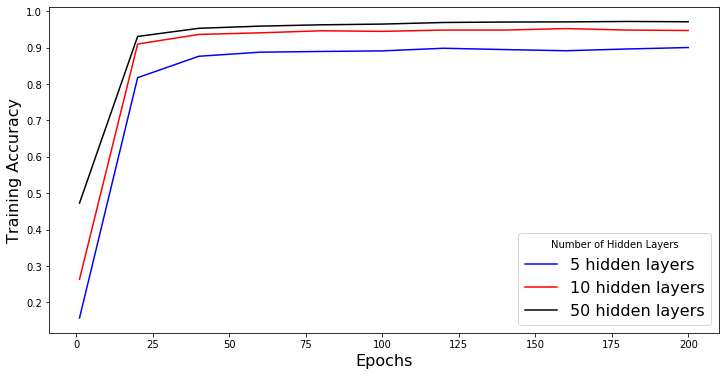

11


In [10]:
# YOUR CODE HERE
nums = np.arange(20,201)
arr = nums[(nums%20==0)]
eps = np.insert(arr,0,1)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.plot(eps, nns[0].acc_train_array, color="blue", label=str(hidden_layer_dims[0]) + " hidden layers")
ax.plot(eps, nns[1].acc_train_array, color="red", label=str(hidden_layer_dims[1]) + " hidden layers")
ax.plot(eps, nns[2].acc_train_array, color="black", label=str(hidden_layer_dims[2]) + " hidden layers")
ax.legend(loc="lower right", title="Number of Hidden Layers",fontsize=16)
ax.set_xlabel("Epochs", fontsize=16)
ax.set_ylabel("Training Accuracy", fontsize=16)
plt.show()
print(len(nns[0].acc_train_array))

Plot testing results below.

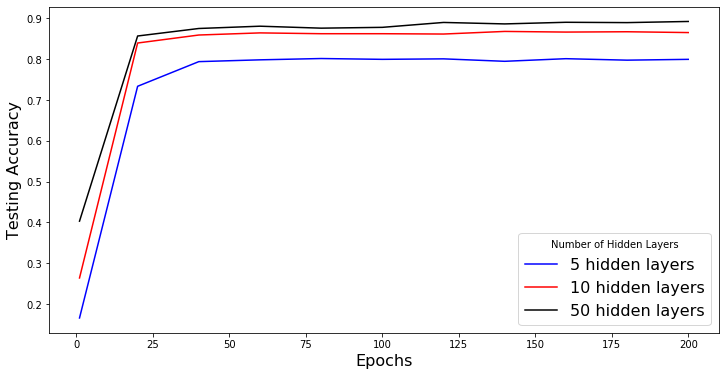

In [11]:
# YOUR CODE HERE
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.plot(eps, nns[0].acc_test_array, color="blue", label=str(hidden_layer_dims[0]) + " hidden layers")
ax.plot(eps, nns[1].acc_test_array, color="red", label=str(hidden_layer_dims[1]) + " hidden layers")
ax.plot(eps, nns[2].acc_test_array, color="black", label=str(hidden_layer_dims[2]) + " hidden layers")
ax.legend(loc="lower right", title="Number of Hidden Layers",fontsize=16)
ax.set_xlabel("Epochs", fontsize=16)
ax.set_ylabel("Testing Accuracy", fontsize=16)
plt.show()

Give your explanation below.

After trying several values for the number of hidden layers, it appears that at around 25 epochs the performance generally converges no matter the number of hidden layers. Hpwever, the more hidden layers the better the performance.

**Extra Credit [10 points]:** Implement dropout by filling the `back_prop_dropout` function and update the `SGD_train` function to use it. Explain the impact of dropout on performance.

In [12]:
hidden_layer_dimensions = 60
nn = Network([input_dimensions, hidden_layer_dimensions, output_dimensions], keep_prob=0.5)
nn.SGD_train(train, epochs=400, eta=0.1, lam=0, verbose=True, test=test)

masks:  [array([[0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.]]), array([[0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.]])]
masks:  [array([[0.],
       [2.],
       [2.],
       [2.],
       [0.],
   

masks:  [array([[2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.]]), array([[0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.]])]
masks:  [array([[2.],
       [2.],
       [0.],
       [0.],
       [2.],
   

masks:  [array([[2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.]]), array([[2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.]])]
masks:  [array([[2.],
       [0.],
       [0.],
       [0.],
       [0.],
   

masks:  [array([[0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.]]), array([[0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.]])]
masks:  [array([[2.],
       [2.],
       [2.],
       [2.],
       [2.],
   

masks:  [array([[0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.]]), array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.]])]
masks:  [array([[2.],
       [0.],
       [2.],
       [2.],
       [0.],
   

masks:  [array([[0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.]]), array([[0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.]])]
masks:  [array([[0.],
       [0.],
       [0.],
       [2.],
       [0.],
   

masks:  [array([[0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.]]), array([[0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.]])]
masks:  [array([[2.],
       [0.],
       [2.],
       [2.],
       [2.],
   

masks:  [array([[2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.]]), array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.]])]
masks:  [array([[2.],
       [2.],
       [2.],
       [0.],
       [2.],
   

masks:  [array([[2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.]]), array([[2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.]])]
masks:  [array([[0.],
       [0.],
       [2.],
       [2.],
       [0.],
   

       [0.]])]
masks:  [array([[2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.]]), array([[2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.]])]
masks:  [array([[0.],
       [2.],
       [0.],
       [0.],
 

masks:  [array([[0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.]]), array([[2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.]])]
masks:  [array([[0.],
       [0.],
       [2.],
       [0.],
       [2.],
   

masks:  [array([[0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.]]), array([[0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.]])]
masks:  [array([[2.],
       [0.],
       [2.],
       [2.],
       [0.],
   

masks:  [array([[2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.]]), array([[0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.]])]
masks:  [array([[2.],
       [2.],
       [2.],
       [0.],
       [2.],
   

masks:  [array([[2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.]]), array([[0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.]])]
masks:  [array([[2.],
       [2.],
       [2.],
       [0.],
       [2.],
   

masks:  [array([[0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.]]), array([[0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.]])]
masks:  [array([[2.],
       [0.],
       [0.],
       [0.],
       [0.],
   

       [0.]])]
masks:  [array([[2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.]]), array([[0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.]])]
masks:  [array([[2.],
       [2.],
       [0.],
       [0.],
 

masks:  [array([[2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.]]), array([[0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.]])]
masks:  [array([[0.],
       [0.],
       [2.],
       [0.],
       [0.],
   

masks:  [array([[0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.]]), array([[0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.]])]
masks:  [array([[2.],
       [0.],
       [0.],
       [0.],
       [2.],
   

masks:  [array([[2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.]]), array([[2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.]])]
masks:  [array([[0.],
       [0.],
       [0.],
       [0.],
       [2.],
   

masks:  [array([[0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.]]), array([[0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.]])]
masks:  [array([[0.],
       [2.],
       [0.],
       [2.],
       [2.],
   

masks:  [array([[2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.]]), array([[2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.]])]
masks:  [array([[2.],
       [0.],
       [2.],
       [0.],
       [0.],
   

masks:  [array([[2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.]]), array([[0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.]])]
masks:  [array([[0.],
       [0.],
       [2.],
       [0.],
       [2.],
   

masks:  [array([[2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.]]), array([[2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.]])]
masks:  [array([[2.],
       [2.],
       [2.],
       [2.],
       [0.],
   

masks:  [array([[0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.]]), array([[2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.]])]
masks:  [array([[0.],
       [0.],
       [0.],
       [2.],
       [0.],
   

masks:  [array([[2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.]]), array([[0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.]])]
masks:  [array([[0.],
       [0.],
       [2.],
       [2.],
       [0.],
   

masks:  [array([[0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.]]), array([[2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.]])]
masks:  [array([[2.],
       [0.],
       [0.],
       [0.],
       [2.],
   

masks:  [array([[0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.]]), array([[0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.]])]
masks:  [array([[2.],
       [0.],
       [2.],
       [2.],
       [0.],
   

masks:  [array([[0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.]]), array([[0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.]])]
masks:  [array([[2.],
       [2.],
       [2.],
       [2.],
       [2.],
   

masks:  [array([[2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.]]), array([[0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.]])]
masks:  [array([[0.],
       [0.],
       [0.],
       [2.],
       [0.],
   

masks:  [array([[2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.]]), array([[0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.]])]
masks:  [array([[0.],
       [2.],
       [0.],
       [2.],
       [2.],
   

masks:  [array([[2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.]]), array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.]])]
masks:  [array([[2.],
       [2.],
       [2.],
       [2.],
       [2.],
   

masks:  [array([[2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.]]), array([[2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.]])]
masks:  [array([[0.],
       [0.],
       [0.],
       [2.],
       [0.],
   

masks:  [array([[0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.]]), array([[2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.]])]
masks:  [array([[0.],
       [2.],
       [2.],
       [0.],
       [2.],
   

masks:  [array([[2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.]]), array([[2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.]])]
masks:  [array([[2.],
       [0.],
       [2.],
       [0.],
       [2.],
   

masks:  [array([[2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.]]), array([[0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.]])]
masks:  [array([[0.],
       [0.],
       [0.],
       [2.],
       [0.],
   

masks:  [array([[2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.]]), array([[0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.]])]
masks:  [array([[2.],
       [2.],
       [0.],
       [2.],
       [2.],
   

       [2.]])]
masks:  [array([[0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.]]), array([[2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.]])]
masks:  [array([[2.],
       [2.],
       [2.],
       [0.],
 

masks:  [array([[2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.]]), array([[0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.]])]
masks:  [array([[0.],
       [0.],
       [0.],
       [0.],
       [2.],
   

masks:  [array([[2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.]]), array([[0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.]])]
masks:  [array([[2.],
       [2.],
       [2.],
       [2.],
       [2.],
   

masks:  [array([[0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.]]), array([[2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.]])]
masks:  [array([[0.],
       [2.],
       [0.],
       [0.],
       [0.],
   

masks:  [array([[0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.]]), array([[0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.]])]
masks:  [array([[2.],
       [0.],
       [0.],
       [0.],
       [0.],
   

masks:  [array([[2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.]]), array([[0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.]])]
masks:  [array([[0.],
       [2.],
       [2.],
       [2.],
       [0.],
   

masks:  [array([[0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]]), array([[0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.]])]
masks:  [array([[2.],
       [2.],
       [0.],
       [2.],
       [0.],
   

masks:  [array([[2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.]]), array([[0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.]])]
masks:  [array([[2.],
       [2.],
       [0.],
       [2.],
       [2.],
   

Epoch    1: Train    0.13405, Test    0.12605
masks:  [array([[2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.]]), array([[2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.]])]
masks:  [array([[0.],
       [2

masks:  [array([[0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.]]), array([[0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.]])]
masks:  [array([[2.],
       [0.],
       [2.],
       [0.],
       [2.],
   

masks:  [array([[0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.]]), array([[0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.]])]
masks:  [array([[0.],
       [2.],
       [0.],
       [0.],
       [0.],
   

masks:  [array([[2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.]]), array([[2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.]])]
masks:  [array([[2.],
       [0.],
       [2.],
       [2.],
       [0.],
   

masks:  [array([[0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.]]), array([[2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.]])]
masks:  [array([[2.],
       [2.],
       [2.],
       [2.],
       [2.],
   

masks:  [array([[2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.]]), array([[0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.]])]
masks:  [array([[0.],
       [0.],
       [0.],
       [0.],
       [2.],
   

masks:  [array([[2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.]]), array([[2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.]])]
masks:  [array([[2.],
       [2.],
       [2.],
       [2.],
       [2.],
   

masks:  [array([[2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.]]), array([[2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.]])]
masks:  [array([[2.],
       [0.],
       [0.],
       [2.],
       [2.],
   

masks:  [array([[0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.]]), array([[2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.]])]
masks:  [array([[2.],
       [2.],
       [2.],
       [0.],
       [0.],
   

masks:  [array([[0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.]]), array([[0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.]])]
masks:  [array([[2.],
       [0.],
       [2.],
       [2.],
       [0.],
   

masks:  [array([[0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.]]), array([[0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.]])]
masks:  [array([[0.],
       [2.],
       [0.],
       [2.],
       [0.],
   

masks:  [array([[2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.]]), array([[0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.]])]
masks:  [array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
   

masks:  [array([[0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.]]), array([[2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.]])]
masks:  [array([[2.],
       [2.],
       [2.],
       [0.],
       [0.],
   

masks:  [array([[2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.]]), array([[0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.]])]
masks:  [array([[2.],
       [2.],
       [2.],
       [2.],
       [0.],
   

       [2.]])]
masks:  [array([[0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.]]), array([[0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.]])]
masks:  [array([[0.],
       [0.],
       [0.],
       [0.],
 

masks:  [array([[0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.]]), array([[0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.]])]
masks:  [array([[2.],
       [2.],
       [0.],
       [0.],
       [2.],
   

masks:  [array([[2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.]]), array([[0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.]])]
masks:  [array([[2.],
       [0.],
       [2.],
       [0.],
       [2.],
   

masks:  [array([[0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.]]), array([[0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.]])]
masks:  [array([[2.],
       [2.],
       [2.],
       [0.],
       [0.],
   

masks:  [array([[0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.]]), array([[0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.]])]
masks:  [array([[2.],
       [2.],
       [0.],
       [0.],
       [2.],
   

masks:  [array([[0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.]]), array([[0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.]])]
masks:  [array([[2.],
       [0.],
       [2.],
       [2.],
       [0.],
   

masks:  [array([[2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.]]), array([[2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.]])]
masks:  [array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
   

masks:  [array([[2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.]]), array([[2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.]])]
masks:  [array([[0.],
       [2.],
       [2.],
       [0.],
       [2.],
   

masks:  [array([[2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.]]), array([[0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.]])]
masks:  [array([[2.],
       [0.],
       [0.],
       [0.],
       [2.],
   

masks:  [array([[2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.]]), array([[0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.]])]
masks:  [array([[2.],
       [2.],
       [2.],
       [2.],
       [0.],
   

masks:  [array([[0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.]]), array([[2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.]])]
masks:  [array([[0.],
       [2.],
       [0.],
       [0.],
       [2.],
   

masks:  [array([[2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.]]), array([[0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.]])]
masks:  [array([[2.],
       [0.],
       [0.],
       [0.],
       [2.],
   

masks:  [array([[2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.]]), array([[0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.]])]
masks:  [array([[0.],
       [2.],
       [2.],
       [2.],
       [2.],
   

       [2.]])]
masks:  [array([[0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.]]), array([[0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.]])]
masks:  [array([[2.],
       [0.],
       [0.],
       [2.],
 

       [0.]])]
masks:  [array([[0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.]]), array([[2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.]])]
masks:  [array([[0.],
       [2.],
       [0.],
       [0.],
 

masks:  [array([[0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.]]), array([[2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.]])]
masks:  [array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
   

masks:  [array([[2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.]]), array([[0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.]])]
masks:  [array([[0.],
       [2.],
       [0.],
       [0.],
       [0.],
   

masks:  [array([[0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.]]), array([[2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.]])]
masks:  [array([[2.],
       [0.],
       [2.],
       [0.],
       [0.],
   

       [2.]])]
masks:  [array([[0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.]]), array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.]])]
masks:  [array([[2.],
       [2.],
       [2.],
       [0.],
 

masks:  [array([[0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.]]), array([[0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.]])]
masks:  [array([[2.],
       [2.],
       [2.],
       [2.],
       [2.],
   

masks:  [array([[0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.]]), array([[2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.]])]
masks:  [array([[2.],
       [0.],
       [0.],
       [2.],
       [2.],
   

masks:  [array([[0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.]]), array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.]])]
masks:  [array([[0.],
       [0.],
       [0.],
       [2.],
       [2.],
   

masks:  [array([[0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.]]), array([[2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.]])]
masks:  [array([[0.],
       [0.],
       [0.],
       [2.],
       [0.],
   

masks:  [array([[2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.]]), array([[2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.]])]
masks:  [array([[0.],
       [2.],
       [2.],
       [0.],
       [0.],
   

masks:  [array([[2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.]]), array([[0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.]])]
masks:  [array([[0.],
       [0.],
       [0.],
       [0.],
       [2.],
   

masks:  [array([[0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.]]), array([[2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.]])]
masks:  [array([[2.],
       [2.],
       [2.],
       [2.],
       [2.],
   

masks:  [array([[2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.]]), array([[2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.]])]
masks:  [array([[0.],
       [2.],
       [2.],
       [2.],
       [0.],
   

masks:  [array([[2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.]]), array([[2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.]])]
masks:  [array([[2.],
       [0.],
       [0.],
       [2.],
       [0.],
   

masks:  [array([[0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.]]), array([[0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.]])]
masks:  [array([[2.],
       [2.],
       [0.],
       [0.],
       [2.],
   

masks:  [array([[2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.]]), array([[2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.]])]
masks:  [array([[2.],
       [0.],
       [2.],
       [2.],
       [0.],
   

masks:  [array([[0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.]]), array([[0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.]])]
masks:  [array([[0.],
       [0.],
       [0.],
       [2.],
       [2.],
   

masks:  [array([[0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.]]), array([[0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.]])]
masks:  [array([[0.],
       [0.],
       [2.],
       [2.],
       [2.],
   

masks:  [array([[0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [0.],
       [2.]]), array([[0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.]])]
masks:  [array([[2.],
       [2.],
       [0.],
       [2.],
       [0.],
   

KeyboardInterrupt: 

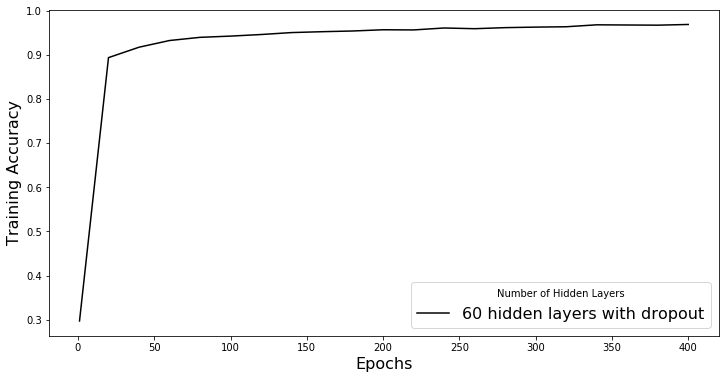

In [13]:
nums = np.arange(20,401)
arr = nums[(nums%20==0)]
eps = np.insert(arr,0,1)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.plot(eps, nn.acc_train_array, color="black", label=str(60) + " hidden layers with dropout")
ax.legend(loc="lower right", title="Number of Hidden Layers",fontsize=16)
ax.set_xlabel("Epochs", fontsize=16)
ax.set_ylabel("Training Accuracy", fontsize=16)
plt.show()

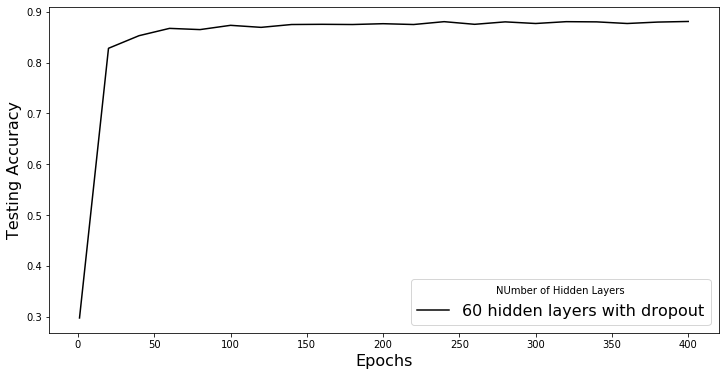

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.plot(eps, nn.acc_test_array, color="black", label=str(hidden_layer_dimensions) + " hidden layers with dropout")
ax.legend(loc="lower right", title="NUmber of Hidden Layers",fontsize=16)
ax.set_xlabel("Epochs", fontsize=16)
ax.set_ylabel("Testing Accuracy", fontsize=16)
plt.show()

My idea was to go through each list of "a's" and set some to zero. I think this was the right method , but not sure. The performance was approximately the same with dropout as with 50 layers and no dropout.

[25 Points] Problem 4 - Implement RNN Network to classify whether text is spam or ham 
---

Dataset is obtained from UCI Machine Learning repository consisting of SMS tagged messages (labelled as either **ham** (legitimate) or **spam**) that have been collected for SMS Spam research.

We will now use [Keras](https://keras.io/) to implement a classifier. First upgrade your `pip` package manager to the latest version (Version >19.0). Then install the current stable release for CPU-only of [TensorFlow](https://www.tensorflow.org/install) (version: 2.0.0) as the backend for Keras. We will use [`tf.keras`](https://www.tensorflow.org/api_docs/python/tf/keras) as our Keras API.

Update the snippet below to build a Sequential model with an embedding layer, and an LSTM layer, and a dense layer. This question allows you to get familiar with popular deep learning toolkits and the solution only has a few lines. In practice, there is no need to reinvent the wheels.


Learn more about RNN : https://colah.github.io/posts/2015-08-Understanding-LSTMs/

**Part 1 [15 points]:** Complete the following functions `init`, `train`, and `evaluate` functions and report the accuracy

In [15]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer


class RNN:
    '''
    RNN classifier
    '''

    def __init__(self, train_x, train_y, test_x, test_y, dict_size=5000,
                 example_length=150, embedding_length=32, epoches=5, batch_size=128):
        '''
        initialize RNN model
        :param train_x: training data
        :param train_y: training label
        :param test_x: test data
        :param test_y: test label
        :param epoches: number of epochs to run
        :param batch_size: batch size in training
        :param embedding_length: size of word embedding
        :param example_length: length of examples
        '''
        self.batch_size = batch_size
        self.epoches = epoches
        self.example_len = example_length
        self.dict_size = dict_size
        self.embedding_len = embedding_length

        # preprocess training data
        tok = Tokenizer(num_words=dict_size)
        tok.fit_on_texts(train_x)
        sequences = tok.texts_to_sequences(train_x)
        self.train_x = sequence.pad_sequences(
            sequences, maxlen=self.example_len)
        sequences = tok.texts_to_sequences(test_x)
        self.test_x = sequence.pad_sequences(
            sequences, maxlen=self.example_len)

        self.train_y = train_y
        self.test_y = test_y

        # TODO: build model with Embedding, LSTM and dense layers.
        # Please refer to Sequence classification with LSTM : 
        #     https://keras.io/getting-started/sequential-model-guide/#examples
        # Documentation for LSTM layer in : 
        #     https://keras.io/layers/recurrent/#lstm
        self.model = Sequential()
        # YOUR CODE HERE
        self.model.add(Embedding(input_dim = self.dict_size, output_dim = self.embedding_len, 
                                 input_length = self.example_len))
        self.model.add(LSTM(self.embedding_len))
        self.model.add(Dense(1, activation='sigmoid'))
        self.model.compile(loss='binary_crossentropy',
                           optimizer='adam', metrics=['accuracy'])

    def train(self, verbose=0):
        '''
        fit in data and train model
        please refer to the fit method in https://keras.io/models/model/#fit
        make sure you use batchsize and epochs appropriately.
        :return: None
        '''
        # TODO: fit in data to train your model
        # YOUR CODE HERE
        self.model.fit(x=self.train_x,y=self.train_y,batch_size=self.batch_size,epochs = self.epoches,verbose=verbose)

    def evaluate(self):
        '''
        evaluate trained model
        please refer to the evaluate method in https://keras.io/models/model/#evaluate
        :return: [loss, accuracy]
        '''
        # YOUR CODE HERE
        return self.model.evaluate(x=self.test_x,y=self.test_y,batch_size=self.batch_size)

In [16]:
import pickle
def load_data(location):
    return pickle.load(open(location,'rb'))

In [17]:
train_x, test_x, train_y, test_y = load_data('./data/spam_data.pkl')
rnn = RNN(train_x, train_y, test_x, test_y, epoches=5)
rnn.train(verbose=1)
loss, accuracy = rnn.evaluate()
print('Accuracy for LSTM: ', accuracy)

Train on 4736 samples
Epoch 1/5
4736/4736 [==============================] - 5s 1ms/sample - loss: 0.4888 - accuracy: 0.8545
Epoch 2/5
4736/4736 [==============================] - 3s 673us/sample - loss: 0.2120 - accuracy: 0.9117
Epoch 3/5
4736/4736 [==============================] - 3s 593us/sample - loss: 0.0982 - accuracy: 0.9789
Epoch 4/5
4736/4736 [==============================] - 3s 629us/sample - loss: 0.0604 - accuracy: 0.9888
Epoch 5/5
4736/4736 [==============================] - 3s 578us/sample - loss: 0.0369 - accuracy: 0.9922
836/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Accuracy for LSTM:  0.9964115


In [18]:
print("Accuracy for LSTM: ", accuracy)

Accuracy for LSTM:  0.9964115


**Part 2 [10 points]:** 
* Change the embedding length and experiment with these values: [8, 16, 32, 48, 64].
* Plot training accuracies of different embedding lengths vs. epochs.
* Observe and explain the impact of embedding length in LSTM Model.

In [19]:
RNNs = []
test_accuracy_array = []
for embedding_len in [8,16,32,48,64]:
    train_x, test_x, train_y, test_y = load_data('./data/spam_data.pkl')
    rnn = RNN(train_x, train_y, test_x, test_y, epoches=5, embedding_length=embedding_len)
    RNNs.append(rnn)
    rnn.train(verbose=1)
    loss, accuracy = rnn.evaluate()
    test_accuracy_array.append(accuracy)
    print('Accuracy for LSTM: ', accuracy)

train_accuracy_matrix = np.array(list(map(lambda x: x.model.history.history["accuracy"], RNNs)))

Train on 4736 samples
Epoch 1/5
4736/4736 [==============================] - 3s 608us/sample - loss: 0.6509 - accuracy: 0.8505
Epoch 2/5
4736/4736 [==============================] - 2s 423us/sample - loss: 0.4610 - accuracy: 0.8651
Epoch 3/5
4736/4736 [==============================] - 2s 369us/sample - loss: 0.3057 - accuracy: 0.8725
Epoch 4/5
4736/4736 [==============================] - 2s 359us/sample - loss: 0.1969 - accuracy: 0.9540
Epoch 5/5
4736/4736 [==============================] - 2s 399us/sample - loss: 0.1501 - accuracy: 0.9770
836/1 [==============================================================================================================================================================================================================================================================================================================================================================================================================================================================

Accuracy for LSTM:  0.98444974
Train on 4736 samples
Epoch 1/5
4736/4736 [==============================] - 4s 791us/sample - loss: 0.6255 - accuracy: 0.8402 - loss: 0.6429 - accura
Epoch 2/5
4736/4736 [==============================] - 2s 516us/sample - loss: 0.3249 - accuracy: 0.8651
Epoch 3/5
4736/4736 [==============================] - 2s 484us/sample - loss: 0.1616 - accuracy: 0.9326 - los
Epoch 4/5
4736/4736 [==============================] - 2s 473us/sample - loss: 0.1037 - accuracy: 0.9787
Epoch 5/5
4736/4736 [==============================] - 2s 462us/sample - loss: 0.0775 - accuracy: 0.9875
836/1 [=================================================================================================================================================================================================================================================================================================================================================================================================

Accuracy for LSTM:  0.98564595
Train on 4736 samples
Epoch 1/5
4736/4736 [==============================] - 5s 1ms/sample - loss: 0.5055 - accuracy: 0.8573
Epoch 2/5
4736/4736 [==============================] - 3s 660us/sample - loss: 0.2133 - accuracy: 0.9098
Epoch 3/5
4736/4736 [==============================] - 3s 675us/sample - loss: 0.0967 - accuracy: 0.9791
Epoch 4/5
4736/4736 [==============================] - 3s 658us/sample - loss: 0.0616 - accuracy: 0.9894
Epoch 5/5
4736/4736 [==============================] - 3s 689us/sample - loss: 0.0388 - accuracy: 0.9935
836/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================

Accuracy for LSTM:  0.9964115
Train on 4736 samples
Epoch 1/5
4736/4736 [==============================] - 6s 1ms/sample - loss: 0.4390 - accuracy: 0.8528
Epoch 2/5
4736/4736 [==============================] - 4s 929us/sample - loss: 0.1350 - accuracy: 0.9571
Epoch 3/5
4736/4736 [==============================] - 5s 1ms/sample - loss: 0.0571 - accuracy: 0.9880
Epoch 4/5
4736/4736 [==============================] - 5s 1ms/sample - loss: 0.0314 - accuracy: 0.9937
Epoch 5/5
4736/4736 [==============================] - 5s 1ms/sample - loss: 0.0204 - accuracy: 0.9949
836/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================

Accuracy for LSTM:  0.99282295
Train on 4736 samples
Epoch 1/5
4736/4736 [==============================] - 8s 2ms/sample - loss: 0.4074 - accuracy: 0.8541
Epoch 2/5
4736/4736 [==============================] - 7s 1ms/sample - loss: 0.1119 - accuracy: 0.9734
Epoch 3/5
4736/4736 [==============================] - 7s 2ms/sample - loss: 0.0476 - accuracy: 0.9888
Epoch 4/5
4736/4736 [==============================] - 7s 1ms/sample - loss: 0.0243 - accuracy: 0.9939
Epoch 5/5
4736/4736 [==============================] - 7s 1ms/sample - loss: 0.0147 - accuracy: 0.9964
836/1 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================

Accuracy for LSTM:  0.99760765


Plot training results below.

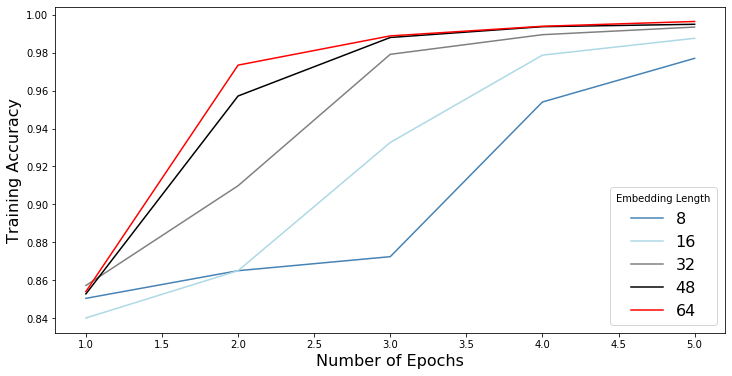

In [20]:
# YOUR CODE HERE
#train_model_accuracy has the results from each of the embedding sizes
#index 0 represents 8 layers and that indexes array is the accuracy over each epoch
#look at hw2 plotting example 2-D
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
eps = [1,2,3,4,5]
ax.plot(eps, train_accuracy_matrix[0], color="steelblue", label=str(8))
ax.plot(eps, train_accuracy_matrix[1], color="lightblue", label=str(16))
ax.plot(eps, train_accuracy_matrix[2], color="grey", label=str(32))
ax.plot(eps, train_accuracy_matrix[3], color="black", label=str(48))
ax.plot(eps, train_accuracy_matrix[4], color="red", label=str(64))
ax.legend(loc="lower right", title="Embedding Length",fontsize=16)
ax.set_xlabel("Number of Epochs", fontsize=16)
ax.set_ylabel("Training Accuracy", fontsize=16)
plt.show()



Give your observation and explanation below.

It appears as though the higher the embedding length, the better the performance. Also, the performance increases as the number of eopchs increases.At 5 epochs 32, 48, and 64 layers all perform about the same.

### Optional survey.
***

We are always interested in your feedback. At the end of each homework, there is a simple anonymous feedback [survey](https://forms.gle/6Kf72C26am1SAjtg6) to solicit your feedback for how to improve the course.